## Goal

Write and evaluate a function to conduct fully stratified dataset sampling and/or train test splits.

A fully stratified sample will have the same, or as close as possible to the same distribution of all variable as in the full dataset.

## Plan

1. Start with an initial pesudorandom sample.
2. Compute Kolmogorov–Smirnov statistic for each variable, comparing sample and dataset.
3. Randomly replace observation with fresh draw from dataset
4. Recompute KS statistic.
5. Repeat

## Motivation

During evaluation of the initial gradient boosting model, I noticed that month does not rank highly in terms of feature importance. This observation did not make sense to me - there is clearly a peak wildfire season in California. The monthly trend in number of fires is present in the dataset but does not seem to be used by the model.

One possible explanation for this is the sampling method used. Drawing a few thousand observations randomly from several million might result is skewed distribution of months, making it hard for the model to learn their importance.

The logical conclusion to this line of reasoning was to think the same of all variables - the distribution in the sample should match the distribution in the full dataset if possible.

In [1]:
import pandas as pd

import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import ks_2samp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
def k_random_sample(data, k):
    # Takes a data frame and an number of observations
    # returns dataframe containing k from n pseudorandom
    # observations with out replacement
    
    n = len(data)
    indices = random.sample(range(0, n), k)
    return data.iloc[indices]

def stratified_sample(data, n):
    # takes a datafram and a sample size n, returns
    # n observations with positive and negative class
    # frequency matched to orignal data
    
    # split positive and negative datsets up
    ignitions = data[data['ignition'] == 1]
    no_ignitions = data[data['ignition'] == 0]
    
    # Calculate ignition & no ignition sample sizes
    ignition_fraction = len(ignitions) / len(data)
    ignition_sample_size = int((n * ignition_fraction))
    no_ignition_sample_size = int((n * (1 - ignition_fraction)))
    
    # sample data
    no_ignitions_sample = k_random_sample(no_ignitions, no_ignition_sample_size)
    ignitions_sample = k_random_sample(ignitions, ignition_sample_size)

    # combine
    sampled_data = no_ignitions_sample.append(ignitions_sample)
    
    return sampled_data

def make_train_test_sample(dataset, sample_size, train_test_split_ratio, rand_seed):
    # Takes data in dataframe, sample size, train test split
    # ratio and random seed. Samples n datapoints from dataset and then
    # runs stratified train test split on sample.
    # return stratified train test split data
    
    column_names = dataset.columns
    
    if 'weather_bin_time' in column_names:
        dataset = dataset.drop('weather_bin_time', axis=1)
    
    sampled_data = stratified_sample(dataset, sample_size)

    y = sampled_data['ignition']
    X = sampled_data.drop('ignition', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y, 
        test_size=train_test_split_ratio, 
        random_state=rand_seed, 
        stratify=y
    )

    return sampled_data, X_train, X_test, y_train, y_test

def two_sample_density_plot(
    plot_location, 
    parent_data, 
    sample_data, 
    data_type, 
    title, 
    xlabel, 
    ylabel, 
    y_scale
):
    parent_values, parent_base = np.histogram(parent_data[data_type], bins=40)
    sample_values, sample_base = np.histogram(sample_data[data_type], bins=40)
    
    parent_cumulative = np.cumsum(parent_values) / len(parent_data)
    sample_cumulative = np.cumsum(sample_values) / len(sample_data)

    ax[plot_location].plot(parent_base[:-1], (parent_values/len(parent_data)))
    ax[plot_location].plot(sample_base[:-1], (sample_values/len(sample_data)))
    ax[plot_location].tick_params(labelsize=12)
    ax[plot_location].set_title(title, fontsize=18)
    ax[plot_location].set_xlabel(xlabel, fontsize=14)
    ax[plot_location].set_ylabel(ylabel, fontsize=15)
    ax[plot_location].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[plot_location].set_yscale(y_scale)
    
def cal_KS_total_statistic(data, sample_data, weather_variables):
    
    total_ks = 0
    
    for variable in weather_variables:
        parent_data = np.array(data[variable])
        sample_data = np.array(sample[variable])

        ks_result = ks_2samp(parent_data, sample_data)
        total_ks = total_ks + ks_result[1]
    
    return total_ks

def replace_sample_subset(sample, fraction, data):
        # choose n randome indexes
        n = len(sample)
        k = int(len(sample)*fraction)
        indices = random.sample(range(0, n), k)
        
        # grab data to replace and remove it from the sample
        data_to_replace = sample.iloc[indices]
        ids_to_replace = data_to_replace.ID
        sample = sample[~sample.ID.isin(ids_to_replace)]
        
        # grab replacement points and remove them from the parent dataset
        new_sample = k_random_sample(data, k)
        sample_ids = sample.ID
        data = data[~data.ID.isin(sample_ids)]
        
        # Add new points to sample and old points back to parent dataset
        sample = sample.append(new_sample)
        data = data.append(data_to_replace)
        
        return data, sample

In [28]:
data_file = '../data/training_data/1992-1997_training_data_daily_mean.csv'

sample_size = 10000
rand_seed = 42
train_test_split_ratio = 0.3

weather_variables = [
    'weather_bin_month','weather_bin_year','air.sfc', 'air.2m', 
    'apcp', 'crain', 'rhum.2m', 'dpt.2m', 'pres.sfc', 'uwnd.10m', 
    'vwnd.10m', 'veg', 'dlwrf', 'dswrf', 'lcdc','hcdc', 'mcdc', 
    'hpbl', 'prate', 'vis', 'ulwrf.sfc', 'ignition'
]

In [4]:
# Load data
data = pd.read_csv(data_file, low_memory=False)

# Shuffel row order
data = data.sample(frac=1).reset_index(drop=True)

First, let's try the old way of doing it - take a pseudo random sample without replacement, stratifying by label and see if the distributions of weather variables are different in the sample vs the parent dataset.

In [5]:
# Take stratified sample of raw data and do stratified train_test split    
sample, X_train, X_test, y_train, y_test = make_train_test_sample(
    data, 
    sample_size, 
    train_test_split_ratio, 
    rand_seed
)

In [6]:
# For each weather variable, conduct 2 sample KS test to compare
# similarity of distributions

for variable in weather_variables:
    parent_data = np.array(data[variable])
    sample_data = np.array(X_train[variable])
    
    ks_result = ks_2samp(parent_data, sample_data)
    
    print("{} KS test p-value: {}".format(variable, np.round(ks_result[1],3)))

weather_bin_month KS test p-value: 0.575
weather_bin_year KS test p-value: 0.743
air.sfc KS test p-value: 0.447
air.2m KS test p-value: 0.505
apcp KS test p-value: 0.877
crain KS test p-value: 0.969
rhum.2m KS test p-value: 0.473
dpt.2m KS test p-value: 0.048
pres.sfc KS test p-value: 0.026
uwnd.10m KS test p-value: 0.412
vwnd.10m KS test p-value: 0.978
veg KS test p-value: 0.716
dlwrf KS test p-value: 0.014
dswrf KS test p-value: 0.972
lcdc KS test p-value: 0.976
hcdc KS test p-value: 0.436
mcdc KS test p-value: 0.681
hpbl KS test p-value: 0.893
prate KS test p-value: 0.396
vis KS test p-value: 0.874
ulwrf.sfc KS test p-value: 0.45


Does not look like we can outright reject the null for any of the tests.... but we do have some small-ish p-values. Let's take a look at the actual distributions by eye.

In [7]:
# Distribution plotting variables

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

fig_rows = 7
fig_cols = 3
plot_height = 35
plot_width = 30

plot_locations = [
    (0,0),(0,1),(0,2),
    (1,0),(1,1),(1,2),
    (2,0),(2,1),(2,2),
    (3,0),(3,1),(3,2),
    (4,0),(4,1),(4,2),
    (5,0),(5,1),(5,2),
    (6,0),(6,1),(6,2)
]

data_types = [
    'air.sfc',  # Surface air temp
    'air.2m',   # Air temp. at 2 meters above surface
    'apcp',     # Accumulated precipitation
    'rhum.2m',  # Relative humidity 2 meters above surface
    'dpt.2m',   # Dew point temp. 2 meters above surface
    'pres.sfc', # Pressure at surface
    'uwnd.10m', # u component of wind (positive = from west) 10 meters above surface
    'vwnd.10m', # v component of wind (positive = from south) 10 meters above surface
    'veg',      # Vegitation at surface
    'dlwrf',    # Downward long wave radiation flux at surface
    'dswrf',    # Downward short wave radiation flux at surface
    'lcdc',     # Low cloud area fraction
    'hcdc',     # High cloud area fraction
    'mcdc',     # Medium cloud area fraction
    'hpbl',     # Planetary boundary layer height
    'prate',    # Precipitation rate
    'vis',      # Visibility
    'ulwrf.sfc',# Upward long wave radiation flux at surface
    'lat',
    'lon',
    'weather_bin_month'
]

plot_titles = [
    'Surface Air Temperature',
    'Air Temperature at 2 Meters',
    'Accumulated Precipitation',
    'Relative Humidity at 2 Meters',
    'Dew Point Temperature',
    'Surface Pressure',
    'East-west Component of Wind',
    'North-south Component of Wind',
    'Vegitation Coverage',
    'Downward Long Wave EM Flux',
    'Downward Short Wave EM Flux',
    'Low Height Cloud Coverage',
    'High Height Cloud Coverage',
    'Medium Height Cloud Coverage',
    'Planetary Boundary Layer Height',
    'Precipitation Rate',
    'Visibility',
    'Upward Long Wave EM Flux',
    'Latitude',
    'Longitude',
    'Month'
]

weather_variable_labels = [
    'Temp. (K)',
    'Temp (K)',
    'Precipitation (in.)',
    'Humidity (%)',
    'Temp (K)',
    'Pressure (kPa)',
    'Speed (mph)',
    'Speed (mph)',
    'Coverage (%)',
    'Flux',
    'Flux',
    'Coverage Fraction',
    'Coverage Fraction',
    'Coverage Fraction',
    'Height (m)',
    'Rate',
    'Visibility',
    'Flux',
    'Latitude',
    'Longitude',
    'Month'
]

y_scales = [
    'linear',
    'linear',
    'log',
    'linear',
    'linear',
    'linear',
    'linear',
    'linear',
    'linear',
    'linear',
    'log',
    'log',
    'log',
    'log',
    'log',
    'log',
    'log',
    'linear',
    'linear',
    'linear',
    'linear'
]

xlabels = weather_variable_labels
ylabels = ['Fraction observations'] * len(xlabels)

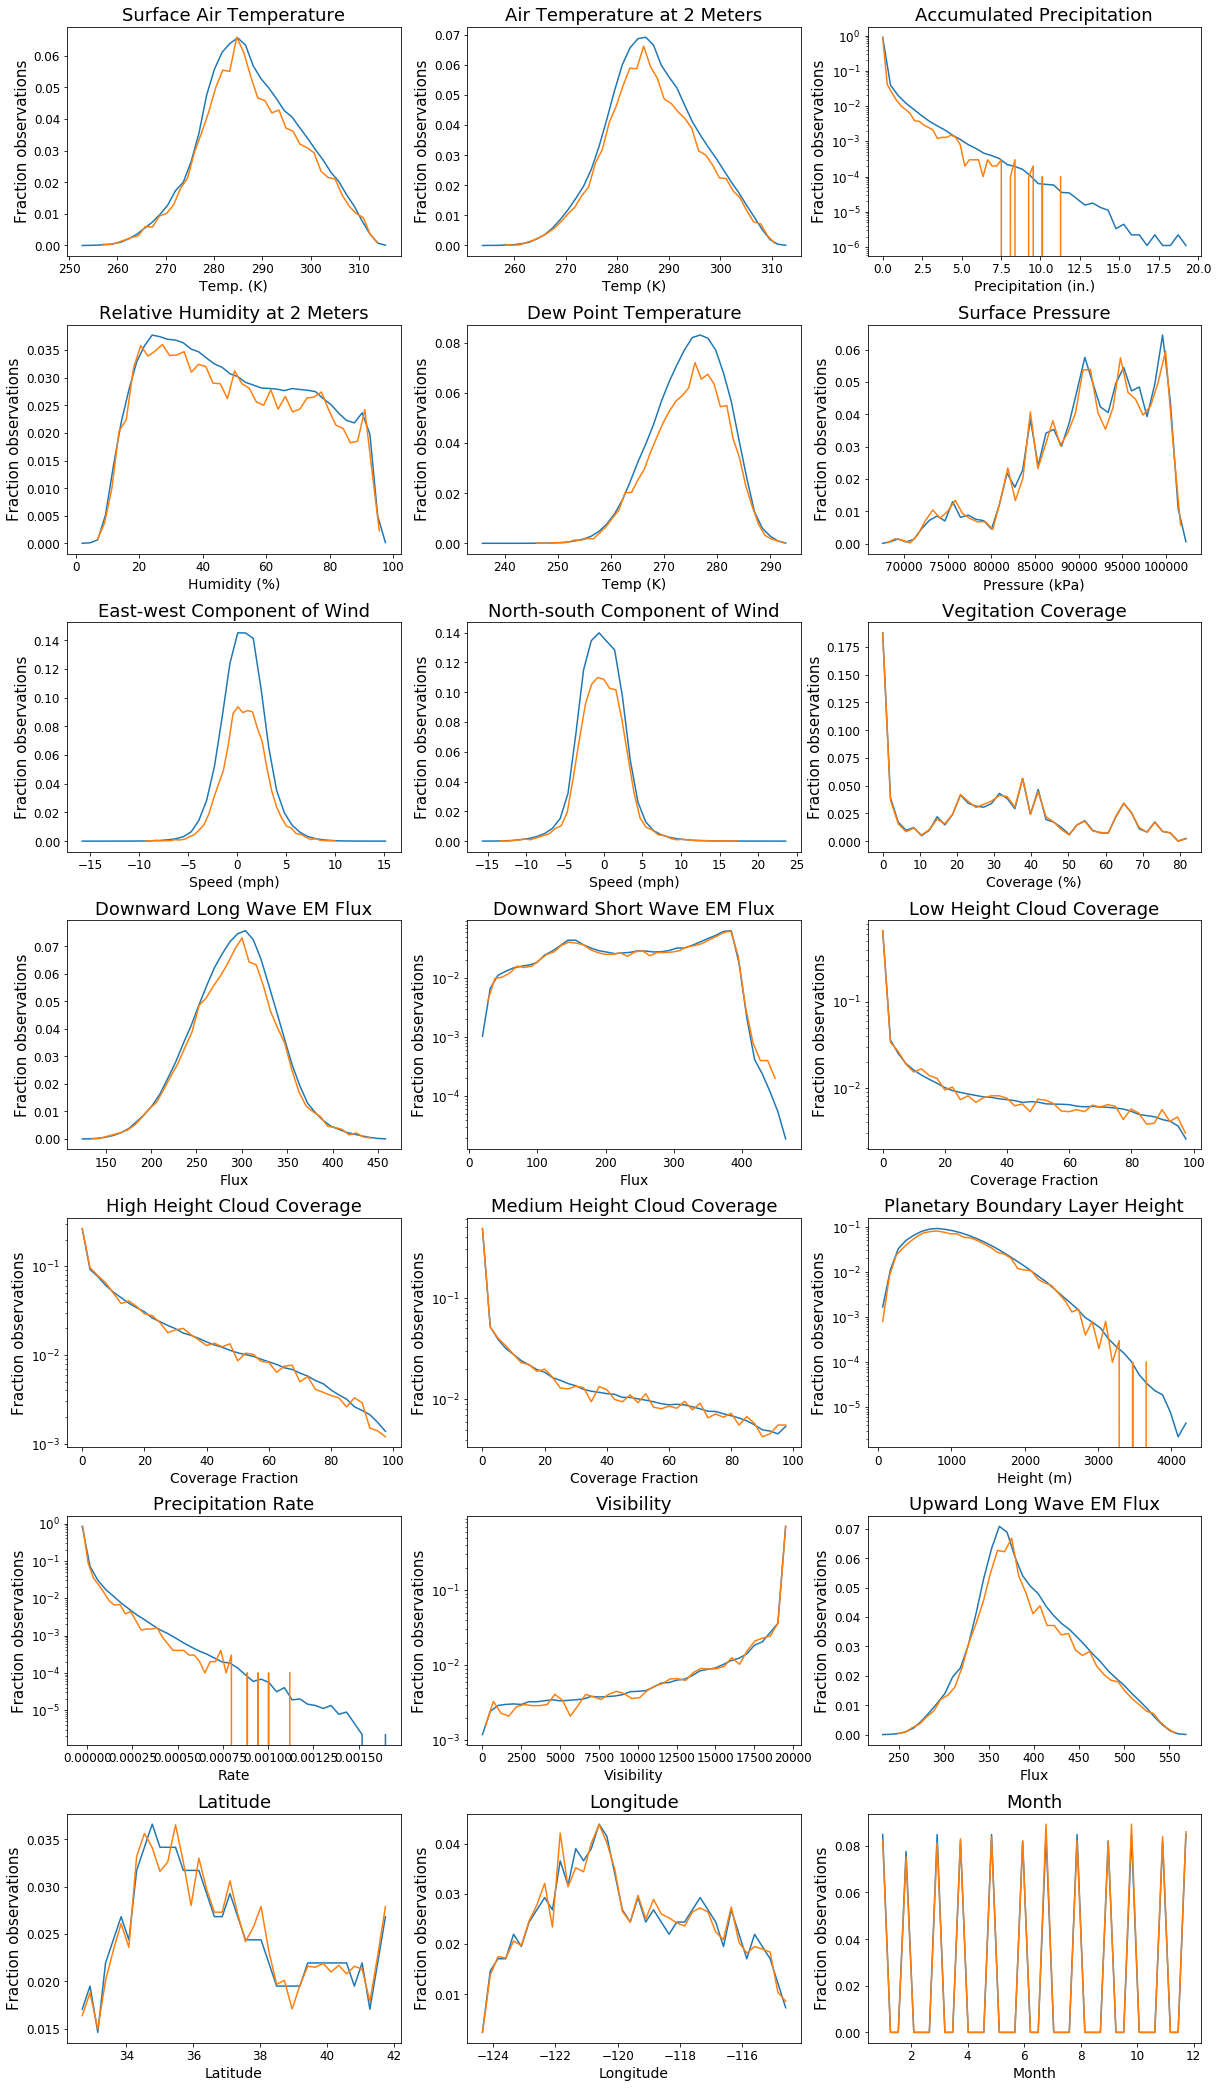

In [8]:
# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = two_sample_density_plot(plot_locations[i], data, sample, data_types[i], plot_titles[i], xlabels[i], ylabels[i], y_scales[i])
    
plt.show()

I think we should drill down further and look at the distributions of weather variables for positive and negative observations between the training set and parent set. Since the positive examples are such a small fraction of the total dataset and we are stratifying our sample, we are going to end up with an even smaller number of positive cases in the sample. This makes it more likely that the weather variable distributions will be different.

In [9]:
raw_positive = data[data['ignition'] == 1]
raw_negative = data[data['ignition'] == 0]
sample_positive = sample[sample['ignition'] == 1]
sample_negative = sample[sample['ignition'] == 0]

print("Percent ignitions parent dataset: {}".format(np.round((len(raw_positive)/len(data))*100),3))
print("Percent ignitions sample dataset: {}".format(np.round((len(sample_positive)/len(sample))*100),3))

print("\nTotal ignitions sample dataset: {}".format(len(sample_positive)))

Percent ignitions parent dataset: 7.0
Percent ignitions sample dataset: 7.0

Total ignitions sample dataset: 697


OK, let's run our KS test again, this time comparing sample positives to parent positives.

In [10]:
for variable in weather_variables:
    parent_data = np.array(raw_positive[variable])
    sample = np.array(sample_positive[variable])
    
    ks_result = ks_2samp(parent_data, sample)
    
    print("{} KS test p-value: {}".format(variable, np.round(ks_result[1],3)))

weather_bin_month KS test p-value: 0.931
weather_bin_year KS test p-value: 0.993
air.sfc KS test p-value: 0.648
air.2m KS test p-value: 0.691
apcp KS test p-value: 0.568
crain KS test p-value: 0.844
rhum.2m KS test p-value: 0.635
dpt.2m KS test p-value: 0.389
pres.sfc KS test p-value: 0.303
uwnd.10m KS test p-value: 0.087
vwnd.10m KS test p-value: 0.059
veg KS test p-value: 0.764
dlwrf KS test p-value: 0.784
dswrf KS test p-value: 0.894
lcdc KS test p-value: 0.991
hcdc KS test p-value: 0.054
mcdc KS test p-value: 0.976
hpbl KS test p-value: 0.104
prate KS test p-value: 0.638
vis KS test p-value: 0.101
ulwrf.sfc KS test p-value: 0.707


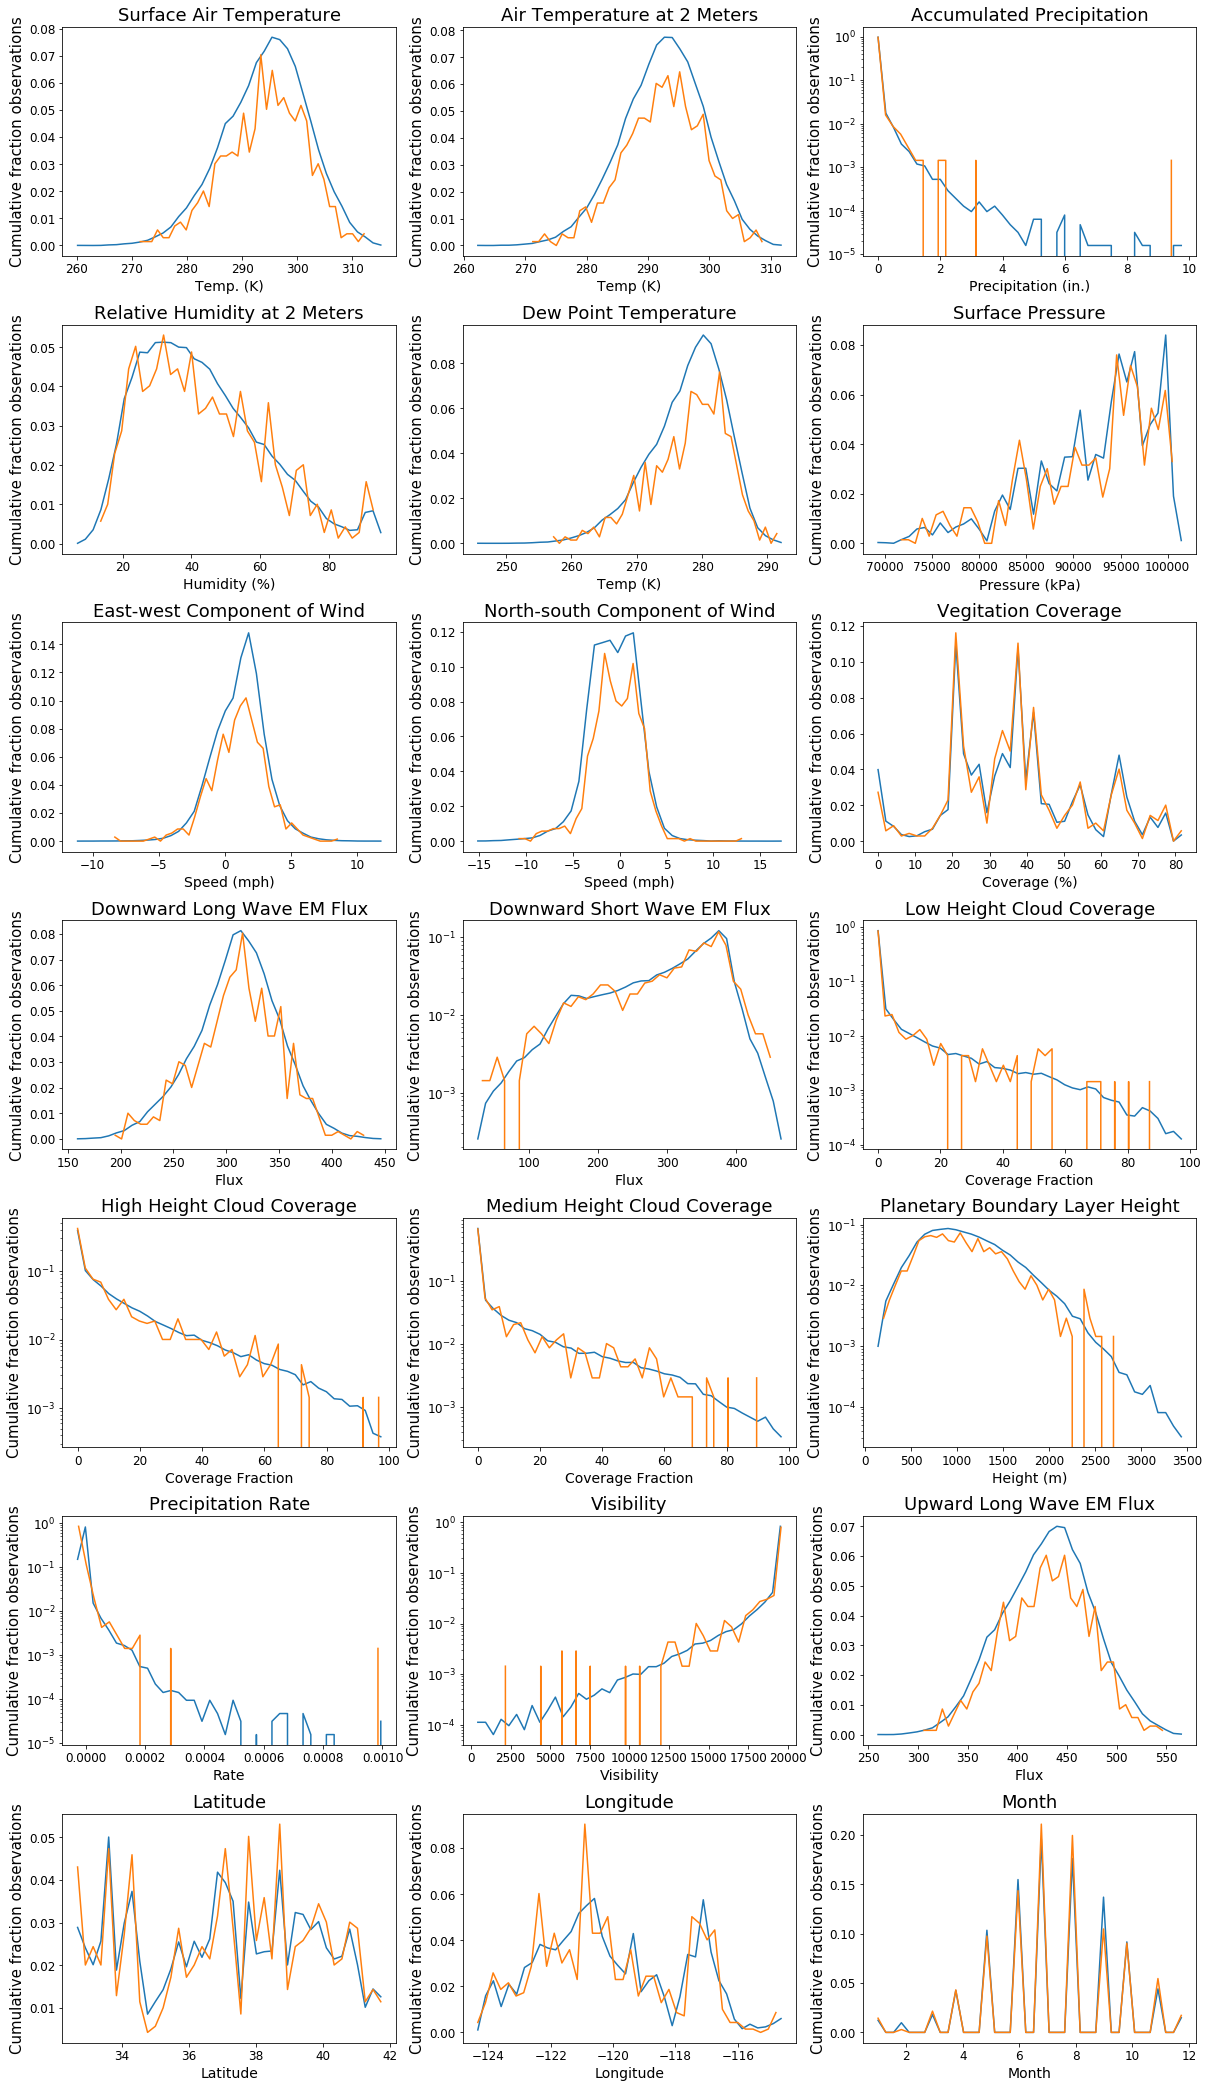

In [11]:
# Make density plots
xlabels = weather_variable_labels
ylabels = ['Cumulative fraction observations'] * len(xlabels)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = two_sample_density_plot(plot_locations[i], raw_positive, sample_positive, data_types[i], plot_titles[i], xlabels[i], ylabels[i], y_scales[i])
    
plt.show()

Alright, stratify everything... not sure how much it will help, but based on what I have seen, it looks like it is worth a shot. Start using a simple brute force random walk approach.

In [12]:
# Add unique id column
data.insert(0, 'ID', range(0, len(data)))
data.head()

,ID,lat,lon,weather_bin_year,weather_bin_month,weather_bin_day,air.sfc,air.2m,apcp,crain,...,dlwrf,dswrf,lcdc,hcdc,mcdc,hpbl,prate,vis,ulwrf.sfc,ignition
0,0,37.82902,-119.5485,1992,4,20,275.545419,276.028226,0.003934,0.000000,...,225.128906,326.717448,0.000000,35.541667,40.604167,918.605410,-3.668961e-07,20009.129521,329.593750,0.0
1,1,33.44765,-115.2705,1995,1,27,284.316467,284.234202,0.003643,0.000000,...,284.839844,182.851563,0.000000,32.375000,39.958333,586.944160,-3.368392e-07,20007.595813,372.450521,0.0
2,2,41.51767,-122.3534,1997,6,29,288.245771,284.121600,1.056847,0.270833,...,293.256510,357.225260,22.145833,36.312500,43.270833,1466.182386,9.163594e-05,16441.525075,394.819010,0.0
3,3,39.59727,-121.4560,1995,4,23,282.806716,286.724828,0.000947,0.000000,...,260.555990,350.026042,0.000000,9.166667,0.000000,783.290297,1.448293e-06,20008.937896,368.549479,0.0
4,4,35.43971,-120.1126,1996,11,29,281.475502,281.445187,0.001033,0.000000,...,242.322917,160.449219,0.312500,4.916667,0.000000,1041.859787,-4.210583e-07,20007.763604,356.770833,0.0


In [29]:
sample_size = 10000

# Grab starting sample

# sample data
sample = k_random_sample(data, sample_size)

# in the first round, our sample is the winning sample
winning_sample = sample

# get IDs of observations in sample
sample_ids = sample.ID

# remove sample observations from parent dataset
data = data[~data.ID.isin(sample_ids)]

In [30]:
winning_ks_list = []
winning_step_nums = []
old_ks = 0
fraction = 0.001

# enter loop to rando replace 10% of the data and calculate KS statistic
for i in range(10000):

    total_ks = cal_KS_total_statistic(data, sample, weather_variables)
    
    if total_ks > old_ks:
        # if we win, replace winning sample
        winning_ks_list.append(total_ks)
        winning_step_nums.append(i)
        print("New winner, round {} - total KS statistic: {}".format(i, np.round(total_ks,3)))
        winning_sample = sample
        old_ks = total_ks
        
        # Then resample and move on
        data, sample = replace_sample_subset(sample, fraction, data)
        
    else:
        # If we did not win, go back to our last winner, resample and move on
        sample = winning_sample
        print("Round {} - total KS statistic: {}".format(i, np.round(total_ks,3)))
        data, sample = replace_sample_subset(sample, fraction, data)       

New winner, round 0 - total KS statistic: 9.668
New winner, round 1 - total KS statistic: 9.842
New winner, round 2 - total KS statistic: 10.528
Round 3 - total KS statistic: 10.198
New winner, round 4 - total KS statistic: 11.039
Round 5 - total KS statistic: 10.425
New winner, round 6 - total KS statistic: 11.361
New winner, round 7 - total KS statistic: 11.365
New winner, round 8 - total KS statistic: 12.0
Round 9 - total KS statistic: 11.575
New winner, round 10 - total KS statistic: 12.493
Round 11 - total KS statistic: 12.435
Round 12 - total KS statistic: 11.916
Round 13 - total KS statistic: 11.721
Round 14 - total KS statistic: 11.365
New winner, round 15 - total KS statistic: 12.88
New winner, round 16 - total KS statistic: 12.941
New winner, round 17 - total KS statistic: 13.374
Round 18 - total KS statistic: 12.539
Round 19 - total KS statistic: 13.032
New winner, round 20 - total KS statistic: 13.661
New winner, round 21 - total KS statistic: 13.797
Round 22 - total KS sta

Round 198 - total KS statistic: 20.299
Round 199 - total KS statistic: 20.234
Round 200 - total KS statistic: 20.283
Round 201 - total KS statistic: 20.288
Round 202 - total KS statistic: 19.867
Round 203 - total KS statistic: 20.292
Round 204 - total KS statistic: 20.167
Round 205 - total KS statistic: 20.161
Round 206 - total KS statistic: 19.814
New winner, round 207 - total KS statistic: 20.426
Round 208 - total KS statistic: 20.102
Round 209 - total KS statistic: 20.025
Round 210 - total KS statistic: 20.216
Round 211 - total KS statistic: 20.183
Round 212 - total KS statistic: 20.204
Round 213 - total KS statistic: 20.107
Round 214 - total KS statistic: 20.37
Round 215 - total KS statistic: 20.08
Round 216 - total KS statistic: 20.324
Round 217 - total KS statistic: 19.867
Round 218 - total KS statistic: 20.142
Round 219 - total KS statistic: 19.763
Round 220 - total KS statistic: 19.913
Round 221 - total KS statistic: 20.061
Round 222 - total KS statistic: 20.226
Round 223 - tot

Round 406 - total KS statistic: 20.845
Round 407 - total KS statistic: 20.776
Round 408 - total KS statistic: 20.874
Round 409 - total KS statistic: 20.672
Round 410 - total KS statistic: 20.941
Round 411 - total KS statistic: 20.817
Round 412 - total KS statistic: 20.594
Round 413 - total KS statistic: 20.868
Round 414 - total KS statistic: 20.934
Round 415 - total KS statistic: 20.739
Round 416 - total KS statistic: 20.895
Round 417 - total KS statistic: 20.685
Round 418 - total KS statistic: 20.906
Round 419 - total KS statistic: 20.807
Round 420 - total KS statistic: 21.067
Round 421 - total KS statistic: 20.505
Round 422 - total KS statistic: 20.646
Round 423 - total KS statistic: 20.899
Round 424 - total KS statistic: 20.868
Round 425 - total KS statistic: 20.56
Round 426 - total KS statistic: 19.774
Round 427 - total KS statistic: 20.646
Round 428 - total KS statistic: 20.651
Round 429 - total KS statistic: 21.039
Round 430 - total KS statistic: 20.857
Round 431 - total KS stati

Round 615 - total KS statistic: 21.053
Round 616 - total KS statistic: 21.226
Round 617 - total KS statistic: 21.19
Round 618 - total KS statistic: 21.013
Round 619 - total KS statistic: 21.335
Round 620 - total KS statistic: 21.338
Round 621 - total KS statistic: 21.35
Round 622 - total KS statistic: 21.181
Round 623 - total KS statistic: 21.044
Round 624 - total KS statistic: 21.401
Round 625 - total KS statistic: 21.044
Round 626 - total KS statistic: 20.819
Round 627 - total KS statistic: 21.309
Round 628 - total KS statistic: 21.288
Round 629 - total KS statistic: 21.205
Round 630 - total KS statistic: 21.42
Round 631 - total KS statistic: 21.23
Round 632 - total KS statistic: 21.377
Round 633 - total KS statistic: 21.269
New winner, round 634 - total KS statistic: 21.582
Round 635 - total KS statistic: 21.382
Round 636 - total KS statistic: 21.529
Round 637 - total KS statistic: 21.189
Round 638 - total KS statistic: 21.309
Round 639 - total KS statistic: 21.357
Round 640 - total

Round 824 - total KS statistic: 21.434
Round 825 - total KS statistic: 21.408
Round 826 - total KS statistic: 21.449
Round 827 - total KS statistic: 21.544
Round 828 - total KS statistic: 21.269
Round 829 - total KS statistic: 21.426
Round 830 - total KS statistic: 21.405
Round 831 - total KS statistic: 21.558
Round 832 - total KS statistic: 21.402
Round 833 - total KS statistic: 21.279
Round 834 - total KS statistic: 21.478
Round 835 - total KS statistic: 21.434
Round 836 - total KS statistic: 21.473
Round 837 - total KS statistic: 21.657
Round 838 - total KS statistic: 21.321
Round 839 - total KS statistic: 21.409
Round 840 - total KS statistic: 21.377
Round 841 - total KS statistic: 21.628
Round 842 - total KS statistic: 21.519
Round 843 - total KS statistic: 21.351
Round 844 - total KS statistic: 21.478
Round 845 - total KS statistic: 21.3
Round 846 - total KS statistic: 21.287
Round 847 - total KS statistic: 21.335
Round 848 - total KS statistic: 21.243
Round 849 - total KS statis

Round 1034 - total KS statistic: 21.407
Round 1035 - total KS statistic: 21.527
Round 1036 - total KS statistic: 21.33
Round 1037 - total KS statistic: 21.554
Round 1038 - total KS statistic: 21.641
Round 1039 - total KS statistic: 21.215
Round 1040 - total KS statistic: 20.671
Round 1041 - total KS statistic: 21.42
Round 1042 - total KS statistic: 21.437
Round 1043 - total KS statistic: 21.426
Round 1044 - total KS statistic: 21.352
Round 1045 - total KS statistic: 21.421
Round 1046 - total KS statistic: 21.481
Round 1047 - total KS statistic: 21.613
Round 1048 - total KS statistic: 21.183
Round 1049 - total KS statistic: 21.61
Round 1050 - total KS statistic: 21.193
Round 1051 - total KS statistic: 21.672
Round 1052 - total KS statistic: 21.34
Round 1053 - total KS statistic: 21.427
Round 1054 - total KS statistic: 21.344
Round 1055 - total KS statistic: 21.296
Round 1056 - total KS statistic: 21.585
Round 1057 - total KS statistic: 21.192
Round 1058 - total KS statistic: 21.364
Roun

Round 1239 - total KS statistic: 21.338
Round 1240 - total KS statistic: 21.588
Round 1241 - total KS statistic: 21.666
Round 1242 - total KS statistic: 21.613
Round 1243 - total KS statistic: 21.485
Round 1244 - total KS statistic: 21.489
Round 1245 - total KS statistic: 21.602
Round 1246 - total KS statistic: 21.528
Round 1247 - total KS statistic: 21.356
Round 1248 - total KS statistic: 21.499
Round 1249 - total KS statistic: 21.642
Round 1250 - total KS statistic: 21.698
Round 1251 - total KS statistic: 21.642
Round 1252 - total KS statistic: 21.292
Round 1253 - total KS statistic: 21.372
Round 1254 - total KS statistic: 21.505
Round 1255 - total KS statistic: 21.53
Round 1256 - total KS statistic: 21.618
Round 1257 - total KS statistic: 21.407
Round 1258 - total KS statistic: 21.47
Round 1259 - total KS statistic: 21.658
Round 1260 - total KS statistic: 21.523
Round 1261 - total KS statistic: 21.549
Round 1262 - total KS statistic: 21.671
Round 1263 - total KS statistic: 21.799
Ro

Round 1445 - total KS statistic: 21.677
Round 1446 - total KS statistic: 21.672
Round 1447 - total KS statistic: 21.308
Round 1448 - total KS statistic: 21.73
Round 1449 - total KS statistic: 21.536
Round 1450 - total KS statistic: 21.657
Round 1451 - total KS statistic: 21.674
Round 1452 - total KS statistic: 21.663
Round 1453 - total KS statistic: 21.236
Round 1454 - total KS statistic: 21.626
Round 1455 - total KS statistic: 21.529
Round 1456 - total KS statistic: 21.641
Round 1457 - total KS statistic: 21.732
Round 1458 - total KS statistic: 21.613
Round 1459 - total KS statistic: 21.254
Round 1460 - total KS statistic: 21.752
Round 1461 - total KS statistic: 21.633
Round 1462 - total KS statistic: 21.606
Round 1463 - total KS statistic: 21.744
Round 1464 - total KS statistic: 21.672
Round 1465 - total KS statistic: 21.648
Round 1466 - total KS statistic: 21.595
Round 1467 - total KS statistic: 21.675
Round 1468 - total KS statistic: 21.591
Round 1469 - total KS statistic: 21.429
R

Round 1651 - total KS statistic: 21.647
Round 1652 - total KS statistic: 21.474
Round 1653 - total KS statistic: 21.499
Round 1654 - total KS statistic: 21.439
Round 1655 - total KS statistic: 21.662
Round 1656 - total KS statistic: 21.536
Round 1657 - total KS statistic: 21.637
Round 1658 - total KS statistic: 21.699
Round 1659 - total KS statistic: 21.599
Round 1660 - total KS statistic: 21.466
Round 1661 - total KS statistic: 21.618
Round 1662 - total KS statistic: 21.585
Round 1663 - total KS statistic: 21.586
Round 1664 - total KS statistic: 21.736
Round 1665 - total KS statistic: 21.695
Round 1666 - total KS statistic: 21.612
Round 1667 - total KS statistic: 21.757
Round 1668 - total KS statistic: 21.259
Round 1669 - total KS statistic: 21.523
Round 1670 - total KS statistic: 21.434
Round 1671 - total KS statistic: 21.524
Round 1672 - total KS statistic: 21.463
Round 1673 - total KS statistic: 21.451
Round 1674 - total KS statistic: 21.608
Round 1675 - total KS statistic: 21.546


Round 1857 - total KS statistic: 21.501
Round 1858 - total KS statistic: 21.561
Round 1859 - total KS statistic: 21.691
Round 1860 - total KS statistic: 21.686
Round 1861 - total KS statistic: 21.413
Round 1862 - total KS statistic: 21.66
Round 1863 - total KS statistic: 21.764
Round 1864 - total KS statistic: 21.611
Round 1865 - total KS statistic: 21.425
Round 1866 - total KS statistic: 21.648
Round 1867 - total KS statistic: 21.712
Round 1868 - total KS statistic: 21.594
Round 1869 - total KS statistic: 21.507
Round 1870 - total KS statistic: 21.556
Round 1871 - total KS statistic: 21.578
Round 1872 - total KS statistic: 21.587
Round 1873 - total KS statistic: 21.651
Round 1874 - total KS statistic: 21.535
Round 1875 - total KS statistic: 21.229
Round 1876 - total KS statistic: 21.719
Round 1877 - total KS statistic: 21.522
Round 1878 - total KS statistic: 21.616
Round 1879 - total KS statistic: 21.562
Round 1880 - total KS statistic: 21.494
Round 1881 - total KS statistic: 21.503
R

Round 2063 - total KS statistic: 21.735
Round 2064 - total KS statistic: 21.57
Round 2065 - total KS statistic: 21.619
Round 2066 - total KS statistic: 21.622
Round 2067 - total KS statistic: 21.587
Round 2068 - total KS statistic: 21.721
Round 2069 - total KS statistic: 21.693
Round 2070 - total KS statistic: 21.663
Round 2071 - total KS statistic: 21.595
Round 2072 - total KS statistic: 21.301
Round 2073 - total KS statistic: 21.62
Round 2074 - total KS statistic: 21.688
Round 2075 - total KS statistic: 21.668
Round 2076 - total KS statistic: 21.657
Round 2077 - total KS statistic: 21.554
Round 2078 - total KS statistic: 21.545
Round 2079 - total KS statistic: 21.601
Round 2080 - total KS statistic: 21.711
Round 2081 - total KS statistic: 21.751
Round 2082 - total KS statistic: 21.65
Round 2083 - total KS statistic: 21.669
Round 2084 - total KS statistic: 21.478
Round 2085 - total KS statistic: 21.273
Round 2086 - total KS statistic: 21.631
Round 2087 - total KS statistic: 21.53
Roun

Round 2269 - total KS statistic: 21.671
Round 2270 - total KS statistic: 21.698
Round 2271 - total KS statistic: 21.698
Round 2272 - total KS statistic: 21.573
Round 2273 - total KS statistic: 21.425
Round 2274 - total KS statistic: 21.595
Round 2275 - total KS statistic: 21.212
Round 2276 - total KS statistic: 21.637
Round 2277 - total KS statistic: 21.539
Round 2278 - total KS statistic: 21.442
Round 2279 - total KS statistic: 21.766
Round 2280 - total KS statistic: 21.541
Round 2281 - total KS statistic: 21.623
Round 2282 - total KS statistic: 21.587
Round 2283 - total KS statistic: 21.671
Round 2284 - total KS statistic: 21.593
Round 2285 - total KS statistic: 21.628
Round 2286 - total KS statistic: 21.6
Round 2287 - total KS statistic: 21.421
Round 2288 - total KS statistic: 21.41
Round 2289 - total KS statistic: 21.665
Round 2290 - total KS statistic: 21.559
Round 2291 - total KS statistic: 21.36
Round 2292 - total KS statistic: 21.354
Round 2293 - total KS statistic: 21.546
Roun

Round 2475 - total KS statistic: 21.427
Round 2476 - total KS statistic: 21.759
Round 2477 - total KS statistic: 21.523
Round 2478 - total KS statistic: 21.394
Round 2479 - total KS statistic: 21.487
Round 2480 - total KS statistic: 21.557
Round 2481 - total KS statistic: 21.447
Round 2482 - total KS statistic: 21.551
Round 2483 - total KS statistic: 21.512
Round 2484 - total KS statistic: 20.719
Round 2485 - total KS statistic: 21.624
Round 2486 - total KS statistic: 21.557
Round 2487 - total KS statistic: 21.484
Round 2488 - total KS statistic: 21.538
Round 2489 - total KS statistic: 21.52
Round 2490 - total KS statistic: 21.466
Round 2491 - total KS statistic: 21.661
Round 2492 - total KS statistic: 21.615
Round 2493 - total KS statistic: 21.596
Round 2494 - total KS statistic: 21.569
Round 2495 - total KS statistic: 21.521
Round 2496 - total KS statistic: 21.612
Round 2497 - total KS statistic: 21.644
Round 2498 - total KS statistic: 21.535
Round 2499 - total KS statistic: 21.716
R

Round 2681 - total KS statistic: 21.594
Round 2682 - total KS statistic: 21.394
Round 2683 - total KS statistic: 21.601
Round 2684 - total KS statistic: 21.175
Round 2685 - total KS statistic: 21.617
Round 2686 - total KS statistic: 21.477
Round 2687 - total KS statistic: 21.599
Round 2688 - total KS statistic: 21.597
Round 2689 - total KS statistic: 21.603
Round 2690 - total KS statistic: 21.465
Round 2691 - total KS statistic: 21.532
Round 2692 - total KS statistic: 21.605
Round 2693 - total KS statistic: 21.552
Round 2694 - total KS statistic: 21.61
Round 2695 - total KS statistic: 21.736
Round 2696 - total KS statistic: 21.479
Round 2697 - total KS statistic: 21.551
Round 2698 - total KS statistic: 21.485
Round 2699 - total KS statistic: 21.062
Round 2700 - total KS statistic: 21.608
Round 2701 - total KS statistic: 21.545
Round 2702 - total KS statistic: 21.475
Round 2703 - total KS statistic: 21.587
Round 2704 - total KS statistic: 21.596
Round 2705 - total KS statistic: 21.474
R

Round 2887 - total KS statistic: 21.358
Round 2888 - total KS statistic: 21.739
Round 2889 - total KS statistic: 21.472
Round 2890 - total KS statistic: 21.71
Round 2891 - total KS statistic: 21.618
Round 2892 - total KS statistic: 21.563
Round 2893 - total KS statistic: 21.729
Round 2894 - total KS statistic: 21.515
Round 2895 - total KS statistic: 21.515
Round 2896 - total KS statistic: 21.778
Round 2897 - total KS statistic: 21.662
Round 2898 - total KS statistic: 21.717
Round 2899 - total KS statistic: 21.433
Round 2900 - total KS statistic: 21.6
Round 2901 - total KS statistic: 21.648
Round 2902 - total KS statistic: 21.497
Round 2903 - total KS statistic: 21.362
Round 2904 - total KS statistic: 21.629
Round 2905 - total KS statistic: 21.695
Round 2906 - total KS statistic: 21.621
Round 2907 - total KS statistic: 21.505
Round 2908 - total KS statistic: 21.642
Round 2909 - total KS statistic: 21.548
Round 2910 - total KS statistic: 21.71
Round 2911 - total KS statistic: 21.723
Roun

Round 3093 - total KS statistic: 21.638
Round 3094 - total KS statistic: 21.5
Round 3095 - total KS statistic: 21.522
Round 3096 - total KS statistic: 21.523
Round 3097 - total KS statistic: 21.605
Round 3098 - total KS statistic: 21.555
Round 3099 - total KS statistic: 21.773
Round 3100 - total KS statistic: 21.588
Round 3101 - total KS statistic: 21.799
Round 3102 - total KS statistic: 21.35
Round 3103 - total KS statistic: 21.534
Round 3104 - total KS statistic: 21.62
Round 3105 - total KS statistic: 21.699
Round 3106 - total KS statistic: 21.733
Round 3107 - total KS statistic: 21.564
Round 3108 - total KS statistic: 21.328
Round 3109 - total KS statistic: 21.617
Round 3110 - total KS statistic: 21.633
Round 3111 - total KS statistic: 20.99
Round 3112 - total KS statistic: 21.383
Round 3113 - total KS statistic: 21.553
Round 3114 - total KS statistic: 21.632
Round 3115 - total KS statistic: 21.664
Round 3116 - total KS statistic: 21.641
Round 3117 - total KS statistic: 21.516
Round

Round 3299 - total KS statistic: 21.589
Round 3300 - total KS statistic: 21.642
Round 3301 - total KS statistic: 21.674
Round 3302 - total KS statistic: 21.657
Round 3303 - total KS statistic: 21.578
Round 3304 - total KS statistic: 21.679
Round 3305 - total KS statistic: 21.587
Round 3306 - total KS statistic: 21.48
Round 3307 - total KS statistic: 21.598
Round 3308 - total KS statistic: 21.479
Round 3309 - total KS statistic: 21.51
Round 3310 - total KS statistic: 21.659
Round 3311 - total KS statistic: 21.587
Round 3312 - total KS statistic: 21.503
Round 3313 - total KS statistic: 21.577
Round 3314 - total KS statistic: 21.553
Round 3315 - total KS statistic: 21.695
Round 3316 - total KS statistic: 21.497
Round 3317 - total KS statistic: 21.673
Round 3318 - total KS statistic: 21.623
Round 3319 - total KS statistic: 21.566
Round 3320 - total KS statistic: 21.775
Round 3321 - total KS statistic: 21.62
Round 3322 - total KS statistic: 21.651
Round 3323 - total KS statistic: 21.702
Rou

Round 3505 - total KS statistic: 21.686
Round 3506 - total KS statistic: 21.68
Round 3507 - total KS statistic: 21.629
Round 3508 - total KS statistic: 21.657
Round 3509 - total KS statistic: 21.287
Round 3510 - total KS statistic: 21.601
Round 3511 - total KS statistic: 21.591
Round 3512 - total KS statistic: 21.747
Round 3513 - total KS statistic: 21.405
Round 3514 - total KS statistic: 21.599
Round 3515 - total KS statistic: 21.544
Round 3516 - total KS statistic: 21.482
Round 3517 - total KS statistic: 21.424
Round 3518 - total KS statistic: 21.466
Round 3519 - total KS statistic: 21.714
Round 3520 - total KS statistic: 21.672
Round 3521 - total KS statistic: 21.457
Round 3522 - total KS statistic: 21.539
Round 3523 - total KS statistic: 21.472
Round 3524 - total KS statistic: 21.639
Round 3525 - total KS statistic: 21.438
Round 3526 - total KS statistic: 21.611
Round 3527 - total KS statistic: 21.615
Round 3528 - total KS statistic: 21.464
Round 3529 - total KS statistic: 21.226
R

Round 3711 - total KS statistic: 21.501
Round 3712 - total KS statistic: 21.57
Round 3713 - total KS statistic: 21.717
Round 3714 - total KS statistic: 21.593
Round 3715 - total KS statistic: 21.683
Round 3716 - total KS statistic: 21.683
Round 3717 - total KS statistic: 21.63
Round 3718 - total KS statistic: 21.694
Round 3719 - total KS statistic: 21.49
Round 3720 - total KS statistic: 21.408
Round 3721 - total KS statistic: 21.532
Round 3722 - total KS statistic: 21.654
Round 3723 - total KS statistic: 21.424
Round 3724 - total KS statistic: 21.532
Round 3725 - total KS statistic: 21.547
Round 3726 - total KS statistic: 21.312
Round 3727 - total KS statistic: 21.633
Round 3728 - total KS statistic: 21.651
Round 3729 - total KS statistic: 21.413
Round 3730 - total KS statistic: 21.573
Round 3731 - total KS statistic: 21.461
Round 3732 - total KS statistic: 21.659
New winner, round 3733 - total KS statistic: 21.83
Round 3734 - total KS statistic: 21.659
Round 3735 - total KS statistic:

Round 3917 - total KS statistic: 21.744
Round 3918 - total KS statistic: 21.665
Round 3919 - total KS statistic: 21.658
Round 3920 - total KS statistic: 21.536
Round 3921 - total KS statistic: 21.504
Round 3922 - total KS statistic: 21.733
Round 3923 - total KS statistic: 21.669
Round 3924 - total KS statistic: 21.525
Round 3925 - total KS statistic: 21.646
Round 3926 - total KS statistic: 21.747
Round 3927 - total KS statistic: 21.685
Round 3928 - total KS statistic: 21.675
Round 3929 - total KS statistic: 21.439
Round 3930 - total KS statistic: 21.596
Round 3931 - total KS statistic: 21.683
Round 3932 - total KS statistic: 21.658
Round 3933 - total KS statistic: 21.657
Round 3934 - total KS statistic: 21.623
Round 3935 - total KS statistic: 21.6
Round 3936 - total KS statistic: 21.754
Round 3937 - total KS statistic: 21.4
Round 3938 - total KS statistic: 21.621
Round 3939 - total KS statistic: 21.699
Round 3940 - total KS statistic: 21.725
Round 3941 - total KS statistic: 21.418
Roun

Round 4123 - total KS statistic: 21.477
Round 4124 - total KS statistic: 21.581
Round 4125 - total KS statistic: 21.55
Round 4126 - total KS statistic: 21.786
Round 4127 - total KS statistic: 21.732
Round 4128 - total KS statistic: 21.601
Round 4129 - total KS statistic: 21.693
Round 4130 - total KS statistic: 21.563
Round 4131 - total KS statistic: 21.676
Round 4132 - total KS statistic: 21.723
Round 4133 - total KS statistic: 21.765
Round 4134 - total KS statistic: 21.811
Round 4135 - total KS statistic: 21.525
Round 4136 - total KS statistic: 21.455
Round 4137 - total KS statistic: 21.656
Round 4138 - total KS statistic: 21.6
Round 4139 - total KS statistic: 21.75
Round 4140 - total KS statistic: 21.573
Round 4141 - total KS statistic: 21.567
Round 4142 - total KS statistic: 21.573
Round 4143 - total KS statistic: 21.765
Round 4144 - total KS statistic: 21.632
Round 4145 - total KS statistic: 21.302
Round 4146 - total KS statistic: 21.601
Round 4147 - total KS statistic: 21.694
Roun

Round 4329 - total KS statistic: 21.68
Round 4330 - total KS statistic: 21.535
Round 4331 - total KS statistic: 21.725
Round 4332 - total KS statistic: 21.7
Round 4333 - total KS statistic: 21.573
Round 4334 - total KS statistic: 21.554
Round 4335 - total KS statistic: 21.592
Round 4336 - total KS statistic: 21.658
Round 4337 - total KS statistic: 21.724
Round 4338 - total KS statistic: 21.599
Round 4339 - total KS statistic: 21.575
Round 4340 - total KS statistic: 21.654
Round 4341 - total KS statistic: 21.707
Round 4342 - total KS statistic: 21.537
Round 4343 - total KS statistic: 21.59
Round 4344 - total KS statistic: 21.66
Round 4345 - total KS statistic: 21.025
Round 4346 - total KS statistic: 21.549
Round 4347 - total KS statistic: 21.441
Round 4348 - total KS statistic: 21.452
Round 4349 - total KS statistic: 21.649
Round 4350 - total KS statistic: 21.746
Round 4351 - total KS statistic: 21.66
Round 4352 - total KS statistic: 21.524
Round 4353 - total KS statistic: 21.755
Round 

Round 4535 - total KS statistic: 21.766
Round 4536 - total KS statistic: 21.459
Round 4537 - total KS statistic: 21.519
Round 4538 - total KS statistic: 21.709
Round 4539 - total KS statistic: 21.791
Round 4540 - total KS statistic: 21.617
Round 4541 - total KS statistic: 21.642
New winner, round 4542 - total KS statistic: 21.855
Round 4543 - total KS statistic: 21.667
Round 4544 - total KS statistic: 21.591
Round 4545 - total KS statistic: 21.708
Round 4546 - total KS statistic: 21.649
Round 4547 - total KS statistic: 21.485
Round 4548 - total KS statistic: 21.298
Round 4549 - total KS statistic: 21.764
Round 4550 - total KS statistic: 21.678
Round 4551 - total KS statistic: 21.203
Round 4552 - total KS statistic: 21.702
Round 4553 - total KS statistic: 21.713
Round 4554 - total KS statistic: 21.603
Round 4555 - total KS statistic: 21.587
Round 4556 - total KS statistic: 21.483
Round 4557 - total KS statistic: 21.629
Round 4558 - total KS statistic: 21.617
Round 4559 - total KS statis

Round 4740 - total KS statistic: 21.66
Round 4741 - total KS statistic: 21.782
Round 4742 - total KS statistic: 21.656
Round 4743 - total KS statistic: 21.62
Round 4744 - total KS statistic: 21.672
Round 4745 - total KS statistic: 21.414
Round 4746 - total KS statistic: 21.473
Round 4747 - total KS statistic: 21.668
Round 4748 - total KS statistic: 21.626
Round 4749 - total KS statistic: 21.781
Round 4750 - total KS statistic: 21.683
Round 4751 - total KS statistic: 21.635
Round 4752 - total KS statistic: 21.716
Round 4753 - total KS statistic: 21.687
Round 4754 - total KS statistic: 21.503
Round 4755 - total KS statistic: 21.706
Round 4756 - total KS statistic: 21.675
Round 4757 - total KS statistic: 21.74
Round 4758 - total KS statistic: 21.644
Round 4759 - total KS statistic: 21.587
Round 4760 - total KS statistic: 21.742
Round 4761 - total KS statistic: 21.702
Round 4762 - total KS statistic: 21.675
Round 4763 - total KS statistic: 21.671
Round 4764 - total KS statistic: 21.582
Rou

Round 4946 - total KS statistic: 21.761
Round 4947 - total KS statistic: 21.74
Round 4948 - total KS statistic: 21.681
Round 4949 - total KS statistic: 21.561
Round 4950 - total KS statistic: 21.739
Round 4951 - total KS statistic: 21.431
Round 4952 - total KS statistic: 21.582
Round 4953 - total KS statistic: 21.562
Round 4954 - total KS statistic: 21.718
Round 4955 - total KS statistic: 21.614
Round 4956 - total KS statistic: 21.304
Round 4957 - total KS statistic: 21.698
Round 4958 - total KS statistic: 21.66
Round 4959 - total KS statistic: 21.781
Round 4960 - total KS statistic: 21.713
Round 4961 - total KS statistic: 21.693
Round 4962 - total KS statistic: 21.741
Round 4963 - total KS statistic: 21.668
Round 4964 - total KS statistic: 21.735
Round 4965 - total KS statistic: 21.722
Round 4966 - total KS statistic: 21.648
Round 4967 - total KS statistic: 21.853
Round 4968 - total KS statistic: 21.603
Round 4969 - total KS statistic: 21.535
Round 4970 - total KS statistic: 21.74
Rou

Round 5152 - total KS statistic: 21.57
Round 5153 - total KS statistic: 21.708
Round 5154 - total KS statistic: 21.494
Round 5155 - total KS statistic: 21.645
Round 5156 - total KS statistic: 21.583
Round 5157 - total KS statistic: 21.724
Round 5158 - total KS statistic: 21.521
Round 5159 - total KS statistic: 21.202
Round 5160 - total KS statistic: 21.517
Round 5161 - total KS statistic: 21.688
Round 5162 - total KS statistic: 21.237
Round 5163 - total KS statistic: 21.702
Round 5164 - total KS statistic: 21.659
Round 5165 - total KS statistic: 21.649
Round 5166 - total KS statistic: 21.614
Round 5167 - total KS statistic: 21.614
Round 5168 - total KS statistic: 21.605
Round 5169 - total KS statistic: 21.552
Round 5170 - total KS statistic: 21.62
Round 5171 - total KS statistic: 21.735
Round 5172 - total KS statistic: 21.247
Round 5173 - total KS statistic: 21.453
Round 5174 - total KS statistic: 21.393
Round 5175 - total KS statistic: 21.685
Round 5176 - total KS statistic: 21.737
Ro

Round 5358 - total KS statistic: 21.578
Round 5359 - total KS statistic: 21.299
Round 5360 - total KS statistic: 21.7
Round 5361 - total KS statistic: 21.72
Round 5362 - total KS statistic: 21.599
Round 5363 - total KS statistic: 21.754
Round 5364 - total KS statistic: 21.663
Round 5365 - total KS statistic: 21.727
Round 5366 - total KS statistic: 21.656
Round 5367 - total KS statistic: 21.666
Round 5368 - total KS statistic: 20.876
Round 5369 - total KS statistic: 21.57
Round 5370 - total KS statistic: 21.717
Round 5371 - total KS statistic: 21.627
Round 5372 - total KS statistic: 21.479
Round 5373 - total KS statistic: 21.686
Round 5374 - total KS statistic: 21.725
Round 5375 - total KS statistic: 21.533
Round 5376 - total KS statistic: 21.586
Round 5377 - total KS statistic: 21.651
Round 5378 - total KS statistic: 21.751
Round 5379 - total KS statistic: 21.584
Round 5380 - total KS statistic: 21.651
Round 5381 - total KS statistic: 21.608
Round 5382 - total KS statistic: 21.506
Roun

Round 5564 - total KS statistic: 21.696
Round 5565 - total KS statistic: 21.684
Round 5566 - total KS statistic: 21.693
Round 5567 - total KS statistic: 21.503
Round 5568 - total KS statistic: 21.574
Round 5569 - total KS statistic: 21.528
Round 5570 - total KS statistic: 21.615
Round 5571 - total KS statistic: 21.65
Round 5572 - total KS statistic: 21.738
Round 5573 - total KS statistic: 21.282
Round 5574 - total KS statistic: 21.627
Round 5575 - total KS statistic: 21.725
Round 5576 - total KS statistic: 21.439
Round 5577 - total KS statistic: 21.711
Round 5578 - total KS statistic: 21.669
Round 5579 - total KS statistic: 21.593
Round 5580 - total KS statistic: 21.485
Round 5581 - total KS statistic: 21.677
Round 5582 - total KS statistic: 21.562
Round 5583 - total KS statistic: 21.412
Round 5584 - total KS statistic: 21.707
Round 5585 - total KS statistic: 21.685
Round 5586 - total KS statistic: 21.531
Round 5587 - total KS statistic: 21.53
Round 5588 - total KS statistic: 21.608
Ro

Round 5770 - total KS statistic: 21.767
Round 5771 - total KS statistic: 21.517
Round 5772 - total KS statistic: 21.647
Round 5773 - total KS statistic: 21.728
Round 5774 - total KS statistic: 21.344
Round 5775 - total KS statistic: 21.729
Round 5776 - total KS statistic: 21.687
Round 5777 - total KS statistic: 21.638
Round 5778 - total KS statistic: 21.755
Round 5779 - total KS statistic: 21.454
Round 5780 - total KS statistic: 21.535
Round 5781 - total KS statistic: 21.81
Round 5782 - total KS statistic: 21.74
Round 5783 - total KS statistic: 21.671
Round 5784 - total KS statistic: 21.753
Round 5785 - total KS statistic: 21.761
Round 5786 - total KS statistic: 21.742
Round 5787 - total KS statistic: 21.358
Round 5788 - total KS statistic: 21.577
Round 5789 - total KS statistic: 21.661
Round 5790 - total KS statistic: 21.667
Round 5791 - total KS statistic: 21.733
Round 5792 - total KS statistic: 21.404
Round 5793 - total KS statistic: 21.621
Round 5794 - total KS statistic: 21.53
Rou

Round 5976 - total KS statistic: 21.568
Round 5977 - total KS statistic: 21.48
Round 5978 - total KS statistic: 21.666
Round 5979 - total KS statistic: 21.65
Round 5980 - total KS statistic: 21.676
Round 5981 - total KS statistic: 21.683
Round 5982 - total KS statistic: 21.65
Round 5983 - total KS statistic: 21.3
Round 5984 - total KS statistic: 21.703
Round 5985 - total KS statistic: 21.72
Round 5986 - total KS statistic: 21.558
Round 5987 - total KS statistic: 21.762
Round 5988 - total KS statistic: 21.406
Round 5989 - total KS statistic: 21.58
Round 5990 - total KS statistic: 21.766
Round 5991 - total KS statistic: 21.767
Round 5992 - total KS statistic: 21.809
Round 5993 - total KS statistic: 21.62
Round 5994 - total KS statistic: 21.574
Round 5995 - total KS statistic: 21.664
Round 5996 - total KS statistic: 21.522
Round 5997 - total KS statistic: 21.769
Round 5998 - total KS statistic: 21.479
Round 5999 - total KS statistic: 21.407
Round 6000 - total KS statistic: 21.669
Round 60

Round 6182 - total KS statistic: 21.674
Round 6183 - total KS statistic: 21.48
Round 6184 - total KS statistic: 21.712
Round 6185 - total KS statistic: 21.704
Round 6186 - total KS statistic: 21.788
Round 6187 - total KS statistic: 21.493
Round 6188 - total KS statistic: 21.716
Round 6189 - total KS statistic: 21.546
Round 6190 - total KS statistic: 21.774
Round 6191 - total KS statistic: 21.714
Round 6192 - total KS statistic: 21.367
Round 6193 - total KS statistic: 21.68
Round 6194 - total KS statistic: 21.657
Round 6195 - total KS statistic: 21.523
Round 6196 - total KS statistic: 21.598
Round 6197 - total KS statistic: 21.577
Round 6198 - total KS statistic: 21.731
Round 6199 - total KS statistic: 21.672
Round 6200 - total KS statistic: 21.598
Round 6201 - total KS statistic: 21.434
Round 6202 - total KS statistic: 21.636
Round 6203 - total KS statistic: 21.665
Round 6204 - total KS statistic: 21.758
Round 6205 - total KS statistic: 21.743
Round 6206 - total KS statistic: 21.726
Ro

Round 6388 - total KS statistic: 21.694
Round 6389 - total KS statistic: 21.61
Round 6390 - total KS statistic: 21.69
Round 6391 - total KS statistic: 21.553
Round 6392 - total KS statistic: 21.656
Round 6393 - total KS statistic: 21.711
Round 6394 - total KS statistic: 21.73
Round 6395 - total KS statistic: 21.547
Round 6396 - total KS statistic: 21.587
Round 6397 - total KS statistic: 21.433
Round 6398 - total KS statistic: 21.696
Round 6399 - total KS statistic: 21.631
Round 6400 - total KS statistic: 21.636
Round 6401 - total KS statistic: 21.619
Round 6402 - total KS statistic: 21.752
Round 6403 - total KS statistic: 21.704
Round 6404 - total KS statistic: 21.759
Round 6405 - total KS statistic: 21.636
Round 6406 - total KS statistic: 21.57
Round 6407 - total KS statistic: 21.654
Round 6408 - total KS statistic: 21.614
Round 6409 - total KS statistic: 21.658
Round 6410 - total KS statistic: 21.746
Round 6411 - total KS statistic: 21.688
Round 6412 - total KS statistic: 21.667
Roun

Round 6594 - total KS statistic: 21.75
Round 6595 - total KS statistic: 21.357
Round 6596 - total KS statistic: 21.634
Round 6597 - total KS statistic: 21.79
Round 6598 - total KS statistic: 21.706
Round 6599 - total KS statistic: 21.65
Round 6600 - total KS statistic: 21.65
Round 6601 - total KS statistic: 21.604
Round 6602 - total KS statistic: 21.647
Round 6603 - total KS statistic: 21.599
Round 6604 - total KS statistic: 21.74
Round 6605 - total KS statistic: 21.579
Round 6606 - total KS statistic: 21.69
Round 6607 - total KS statistic: 21.655
Round 6608 - total KS statistic: 21.679
Round 6609 - total KS statistic: 21.602
Round 6610 - total KS statistic: 21.567
Round 6611 - total KS statistic: 21.641
Round 6612 - total KS statistic: 21.643
Round 6613 - total KS statistic: 21.529
Round 6614 - total KS statistic: 21.467
Round 6615 - total KS statistic: 21.597
Round 6616 - total KS statistic: 21.584
Round 6617 - total KS statistic: 21.763
Round 6618 - total KS statistic: 21.502
Round 

Round 6800 - total KS statistic: 21.568
Round 6801 - total KS statistic: 21.516
Round 6802 - total KS statistic: 21.631
Round 6803 - total KS statistic: 21.612
Round 6804 - total KS statistic: 21.717
Round 6805 - total KS statistic: 21.53
Round 6806 - total KS statistic: 21.469
Round 6807 - total KS statistic: 21.676
Round 6808 - total KS statistic: 21.523
Round 6809 - total KS statistic: 21.677
Round 6810 - total KS statistic: 21.615
Round 6811 - total KS statistic: 21.646
Round 6812 - total KS statistic: 21.278
Round 6813 - total KS statistic: 21.737
Round 6814 - total KS statistic: 21.522
Round 6815 - total KS statistic: 21.72
Round 6816 - total KS statistic: 21.66
Round 6817 - total KS statistic: 21.584
Round 6818 - total KS statistic: 21.619
Round 6819 - total KS statistic: 21.352
Round 6820 - total KS statistic: 21.714
Round 6821 - total KS statistic: 21.656
Round 6822 - total KS statistic: 21.639
Round 6823 - total KS statistic: 21.764
Round 6824 - total KS statistic: 21.672
Rou

Round 7006 - total KS statistic: 21.56
Round 7007 - total KS statistic: 21.575
Round 7008 - total KS statistic: 21.756
Round 7009 - total KS statistic: 21.735
Round 7010 - total KS statistic: 21.588
Round 7011 - total KS statistic: 21.643
Round 7012 - total KS statistic: 21.736
Round 7013 - total KS statistic: 21.632
Round 7014 - total KS statistic: 21.488
Round 7015 - total KS statistic: 21.645
Round 7016 - total KS statistic: 21.575
Round 7017 - total KS statistic: 21.669
Round 7018 - total KS statistic: 21.653
Round 7019 - total KS statistic: 21.639
Round 7020 - total KS statistic: 21.528
Round 7021 - total KS statistic: 21.562
Round 7022 - total KS statistic: 21.734
Round 7023 - total KS statistic: 21.503
Round 7024 - total KS statistic: 21.571
Round 7025 - total KS statistic: 21.56
Round 7026 - total KS statistic: 21.37
Round 7027 - total KS statistic: 21.555
Round 7028 - total KS statistic: 21.621
Round 7029 - total KS statistic: 21.634
Round 7030 - total KS statistic: 21.818
Rou

Round 7212 - total KS statistic: 21.59
Round 7213 - total KS statistic: 21.708
Round 7214 - total KS statistic: 21.744
Round 7215 - total KS statistic: 21.561
Round 7216 - total KS statistic: 21.618
Round 7217 - total KS statistic: 21.714
Round 7218 - total KS statistic: 21.692
Round 7219 - total KS statistic: 21.658
Round 7220 - total KS statistic: 21.669
Round 7221 - total KS statistic: 21.599
Round 7222 - total KS statistic: 21.685
Round 7223 - total KS statistic: 21.627
Round 7224 - total KS statistic: 21.727
Round 7225 - total KS statistic: 21.421
Round 7226 - total KS statistic: 21.779
Round 7227 - total KS statistic: 21.747
Round 7228 - total KS statistic: 21.642
Round 7229 - total KS statistic: 21.523
Round 7230 - total KS statistic: 21.501
Round 7231 - total KS statistic: 21.695
Round 7232 - total KS statistic: 21.386
Round 7233 - total KS statistic: 21.646
Round 7234 - total KS statistic: 21.677
Round 7235 - total KS statistic: 21.313
Round 7236 - total KS statistic: 21.623
R

Round 7418 - total KS statistic: 21.604
Round 7419 - total KS statistic: 21.68
Round 7420 - total KS statistic: 21.769
Round 7421 - total KS statistic: 21.466
Round 7422 - total KS statistic: 21.625
Round 7423 - total KS statistic: 21.462
Round 7424 - total KS statistic: 21.533
Round 7425 - total KS statistic: 21.646
Round 7426 - total KS statistic: 21.633
Round 7427 - total KS statistic: 21.769
Round 7428 - total KS statistic: 21.603
Round 7429 - total KS statistic: 21.417
Round 7430 - total KS statistic: 21.612
Round 7431 - total KS statistic: 21.67
Round 7432 - total KS statistic: 21.518
Round 7433 - total KS statistic: 21.635
Round 7434 - total KS statistic: 21.649
Round 7435 - total KS statistic: 21.21
Round 7436 - total KS statistic: 21.571
Round 7437 - total KS statistic: 21.702
Round 7438 - total KS statistic: 21.701
Round 7439 - total KS statistic: 21.554
Round 7440 - total KS statistic: 21.765
Round 7441 - total KS statistic: 21.644
Round 7442 - total KS statistic: 21.568
Rou

Round 7624 - total KS statistic: 21.667
Round 7625 - total KS statistic: 21.472
Round 7626 - total KS statistic: 21.721
Round 7627 - total KS statistic: 21.812
Round 7628 - total KS statistic: 21.688
Round 7629 - total KS statistic: 21.641
Round 7630 - total KS statistic: 21.482
Round 7631 - total KS statistic: 21.781
Round 7632 - total KS statistic: 21.761
Round 7633 - total KS statistic: 21.476
Round 7634 - total KS statistic: 21.667
Round 7635 - total KS statistic: 21.703
Round 7636 - total KS statistic: 21.791
Round 7637 - total KS statistic: 21.653
Round 7638 - total KS statistic: 21.748
Round 7639 - total KS statistic: 21.687
Round 7640 - total KS statistic: 21.407
Round 7641 - total KS statistic: 21.48
Round 7642 - total KS statistic: 21.584
Round 7643 - total KS statistic: 21.724
Round 7644 - total KS statistic: 21.561
Round 7645 - total KS statistic: 21.626
Round 7646 - total KS statistic: 21.461
Round 7647 - total KS statistic: 21.221
Round 7648 - total KS statistic: 21.561
R

Round 7830 - total KS statistic: 21.677
Round 7831 - total KS statistic: 21.408
Round 7832 - total KS statistic: 21.567
Round 7833 - total KS statistic: 21.567
Round 7834 - total KS statistic: 21.7
Round 7835 - total KS statistic: 21.789
Round 7836 - total KS statistic: 21.58
Round 7837 - total KS statistic: 21.544
Round 7838 - total KS statistic: 21.651
Round 7839 - total KS statistic: 21.676
Round 7840 - total KS statistic: 21.695
Round 7841 - total KS statistic: 21.663
Round 7842 - total KS statistic: 21.717
Round 7843 - total KS statistic: 21.666
Round 7844 - total KS statistic: 21.659
Round 7845 - total KS statistic: 21.16
Round 7846 - total KS statistic: 21.704
Round 7847 - total KS statistic: 21.416
Round 7848 - total KS statistic: 21.687
Round 7849 - total KS statistic: 21.756
Round 7850 - total KS statistic: 21.714
Round 7851 - total KS statistic: 21.495
Round 7852 - total KS statistic: 21.542
Round 7853 - total KS statistic: 21.603
Round 7854 - total KS statistic: 21.706
Roun

Round 8036 - total KS statistic: 21.683
Round 8037 - total KS statistic: 21.748
Round 8038 - total KS statistic: 21.586
Round 8039 - total KS statistic: 21.79
Round 8040 - total KS statistic: 21.665
Round 8041 - total KS statistic: 21.719
Round 8042 - total KS statistic: 21.477
Round 8043 - total KS statistic: 21.482
Round 8044 - total KS statistic: 21.623
Round 8045 - total KS statistic: 21.635
Round 8046 - total KS statistic: 21.521
Round 8047 - total KS statistic: 21.557
Round 8048 - total KS statistic: 21.554
Round 8049 - total KS statistic: 21.748
Round 8050 - total KS statistic: 21.516
Round 8051 - total KS statistic: 21.708
Round 8052 - total KS statistic: 21.673
Round 8053 - total KS statistic: 21.441
Round 8054 - total KS statistic: 21.7
Round 8055 - total KS statistic: 21.649
Round 8056 - total KS statistic: 21.695
Round 8057 - total KS statistic: 21.679
Round 8058 - total KS statistic: 21.416
Round 8059 - total KS statistic: 21.761
Round 8060 - total KS statistic: 21.666
Rou

Round 8242 - total KS statistic: 21.672
Round 8243 - total KS statistic: 21.604
Round 8244 - total KS statistic: 21.667
Round 8245 - total KS statistic: 21.4
Round 8246 - total KS statistic: 21.656
Round 8247 - total KS statistic: 21.572
Round 8248 - total KS statistic: 21.501
Round 8249 - total KS statistic: 21.682
Round 8250 - total KS statistic: 21.688
Round 8251 - total KS statistic: 21.678
Round 8252 - total KS statistic: 21.68
Round 8253 - total KS statistic: 21.568
Round 8254 - total KS statistic: 21.245
Round 8255 - total KS statistic: 21.633
Round 8256 - total KS statistic: 21.387
Round 8257 - total KS statistic: 21.691
Round 8258 - total KS statistic: 21.755
Round 8259 - total KS statistic: 21.417
Round 8260 - total KS statistic: 21.507
Round 8261 - total KS statistic: 21.746
Round 8262 - total KS statistic: 21.397
Round 8263 - total KS statistic: 21.616
Round 8264 - total KS statistic: 21.647
Round 8265 - total KS statistic: 21.54
Round 8266 - total KS statistic: 21.662
Roun

Round 8448 - total KS statistic: 21.665
Round 8449 - total KS statistic: 21.555
Round 8450 - total KS statistic: 21.655
Round 8451 - total KS statistic: 21.727
Round 8452 - total KS statistic: 21.594
Round 8453 - total KS statistic: 21.663
Round 8454 - total KS statistic: 21.657
Round 8455 - total KS statistic: 21.697
Round 8456 - total KS statistic: 21.616
Round 8457 - total KS statistic: 21.599
Round 8458 - total KS statistic: 21.637
Round 8459 - total KS statistic: 21.533
Round 8460 - total KS statistic: 21.641
Round 8461 - total KS statistic: 21.686
Round 8462 - total KS statistic: 21.477
Round 8463 - total KS statistic: 21.652
Round 8464 - total KS statistic: 21.754
Round 8465 - total KS statistic: 21.521
Round 8466 - total KS statistic: 21.624
Round 8467 - total KS statistic: 21.608
Round 8468 - total KS statistic: 21.608
Round 8469 - total KS statistic: 21.543
Round 8470 - total KS statistic: 21.609
Round 8471 - total KS statistic: 21.661
Round 8472 - total KS statistic: 21.654


Round 8654 - total KS statistic: 21.768
Round 8655 - total KS statistic: 21.715
Round 8656 - total KS statistic: 21.672
Round 8657 - total KS statistic: 21.701
Round 8658 - total KS statistic: 21.604
Round 8659 - total KS statistic: 21.485
Round 8660 - total KS statistic: 21.735
Round 8661 - total KS statistic: 21.715
Round 8662 - total KS statistic: 21.618
Round 8663 - total KS statistic: 21.585
Round 8664 - total KS statistic: 21.668
Round 8665 - total KS statistic: 21.486
Round 8666 - total KS statistic: 21.729
Round 8667 - total KS statistic: 21.764
Round 8668 - total KS statistic: 21.521
Round 8669 - total KS statistic: 21.652
Round 8670 - total KS statistic: 21.711
Round 8671 - total KS statistic: 21.312
Round 8672 - total KS statistic: 21.678
Round 8673 - total KS statistic: 21.741
Round 8674 - total KS statistic: 21.617
Round 8675 - total KS statistic: 21.614
Round 8676 - total KS statistic: 21.633
Round 8677 - total KS statistic: 21.74
Round 8678 - total KS statistic: 21.493
R

Round 8860 - total KS statistic: 21.69
Round 8861 - total KS statistic: 21.696
Round 8862 - total KS statistic: 21.599
Round 8863 - total KS statistic: 21.636
Round 8864 - total KS statistic: 21.618
Round 8865 - total KS statistic: 21.596
Round 8866 - total KS statistic: 21.676
Round 8867 - total KS statistic: 21.65
Round 8868 - total KS statistic: 21.675
Round 8869 - total KS statistic: 21.635
Round 8870 - total KS statistic: 21.456
Round 8871 - total KS statistic: 21.609
Round 8872 - total KS statistic: 21.688
Round 8873 - total KS statistic: 21.573
Round 8874 - total KS statistic: 21.53
Round 8875 - total KS statistic: 21.742
Round 8876 - total KS statistic: 21.562
Round 8877 - total KS statistic: 21.501
Round 8878 - total KS statistic: 21.626
Round 8879 - total KS statistic: 21.583
Round 8880 - total KS statistic: 21.659
Round 8881 - total KS statistic: 21.511
Round 8882 - total KS statistic: 21.639
Round 8883 - total KS statistic: 21.637
Round 8884 - total KS statistic: 21.581
Rou

Round 9066 - total KS statistic: 21.723
Round 9067 - total KS statistic: 21.464
Round 9068 - total KS statistic: 21.562
Round 9069 - total KS statistic: 21.555
Round 9070 - total KS statistic: 21.624
Round 9071 - total KS statistic: 21.665
Round 9072 - total KS statistic: 21.671
Round 9073 - total KS statistic: 21.551
Round 9074 - total KS statistic: 21.473
Round 9075 - total KS statistic: 21.791
Round 9076 - total KS statistic: 21.533
Round 9077 - total KS statistic: 21.684
Round 9078 - total KS statistic: 21.673
Round 9079 - total KS statistic: 21.523
Round 9080 - total KS statistic: 21.63
Round 9081 - total KS statistic: 21.62
Round 9082 - total KS statistic: 21.668
Round 9083 - total KS statistic: 21.547
Round 9084 - total KS statistic: 21.603
Round 9085 - total KS statistic: 21.673
Round 9086 - total KS statistic: 21.48
Round 9087 - total KS statistic: 21.487
Round 9088 - total KS statistic: 21.65
Round 9089 - total KS statistic: 21.631
Round 9090 - total KS statistic: 21.602
Roun

Round 9272 - total KS statistic: 21.731
Round 9273 - total KS statistic: 21.771
Round 9274 - total KS statistic: 21.675
Round 9275 - total KS statistic: 21.628
Round 9276 - total KS statistic: 21.696
Round 9277 - total KS statistic: 21.688
Round 9278 - total KS statistic: 21.705
Round 9279 - total KS statistic: 21.705
Round 9280 - total KS statistic: 21.701
Round 9281 - total KS statistic: 21.757
Round 9282 - total KS statistic: 21.649
Round 9283 - total KS statistic: 21.352
Round 9284 - total KS statistic: 21.431
Round 9285 - total KS statistic: 21.722
Round 9286 - total KS statistic: 21.688
Round 9287 - total KS statistic: 21.685
Round 9288 - total KS statistic: 21.559
Round 9289 - total KS statistic: 21.605
Round 9290 - total KS statistic: 21.73
Round 9291 - total KS statistic: 21.733
Round 9292 - total KS statistic: 21.725
Round 9293 - total KS statistic: 21.601
Round 9294 - total KS statistic: 21.561
Round 9295 - total KS statistic: 21.749
Round 9296 - total KS statistic: 21.46
Ro

Round 9478 - total KS statistic: 21.678
Round 9479 - total KS statistic: 21.771
Round 9480 - total KS statistic: 21.662
Round 9481 - total KS statistic: 21.446
Round 9482 - total KS statistic: 21.61
Round 9483 - total KS statistic: 21.641
Round 9484 - total KS statistic: 21.613
Round 9485 - total KS statistic: 21.603
Round 9486 - total KS statistic: 21.634
Round 9487 - total KS statistic: 21.774
Round 9488 - total KS statistic: 21.738
Round 9489 - total KS statistic: 21.355
Round 9490 - total KS statistic: 21.6
Round 9491 - total KS statistic: 21.37
Round 9492 - total KS statistic: 21.677
Round 9493 - total KS statistic: 21.62
Round 9494 - total KS statistic: 21.413
Round 9495 - total KS statistic: 21.701
Round 9496 - total KS statistic: 21.632
Round 9497 - total KS statistic: 21.689
Round 9498 - total KS statistic: 21.613
Round 9499 - total KS statistic: 21.741
Round 9500 - total KS statistic: 21.759
Round 9501 - total KS statistic: 21.666
Round 9502 - total KS statistic: 21.635
Round

Round 9684 - total KS statistic: 21.753
Round 9685 - total KS statistic: 21.637
Round 9686 - total KS statistic: 21.493
Round 9687 - total KS statistic: 21.729
Round 9688 - total KS statistic: 21.493
Round 9689 - total KS statistic: 21.702
Round 9690 - total KS statistic: 21.434
Round 9691 - total KS statistic: 21.554
Round 9692 - total KS statistic: 21.784
Round 9693 - total KS statistic: 21.769
Round 9694 - total KS statistic: 21.705
Round 9695 - total KS statistic: 21.498
Round 9696 - total KS statistic: 21.634
Round 9697 - total KS statistic: 21.381
Round 9698 - total KS statistic: 21.486
Round 9699 - total KS statistic: 21.787
Round 9700 - total KS statistic: 21.676
Round 9701 - total KS statistic: 21.506
Round 9702 - total KS statistic: 21.696
Round 9703 - total KS statistic: 21.34
Round 9704 - total KS statistic: 21.671
Round 9705 - total KS statistic: 21.636
Round 9706 - total KS statistic: 21.61
Round 9707 - total KS statistic: 21.68
Round 9708 - total KS statistic: 21.743
Rou

Round 9890 - total KS statistic: 21.73
Round 9891 - total KS statistic: 21.626
Round 9892 - total KS statistic: 21.602
Round 9893 - total KS statistic: 21.808
Round 9894 - total KS statistic: 21.553
Round 9895 - total KS statistic: 21.587
Round 9896 - total KS statistic: 21.651
Round 9897 - total KS statistic: 21.306
Round 9898 - total KS statistic: 21.649
Round 9899 - total KS statistic: 21.621
Round 9900 - total KS statistic: 21.502
Round 9901 - total KS statistic: 21.61
Round 9902 - total KS statistic: 21.54
Round 9903 - total KS statistic: 21.717
Round 9904 - total KS statistic: 21.737
Round 9905 - total KS statistic: 21.452
Round 9906 - total KS statistic: 21.691
Round 9907 - total KS statistic: 21.579
Round 9908 - total KS statistic: 21.683
Round 9909 - total KS statistic: 21.644
Round 9910 - total KS statistic: 21.706
Round 9911 - total KS statistic: 21.531
Round 9912 - total KS statistic: 21.703
Round 9913 - total KS statistic: 21.684
Round 9914 - total KS statistic: 21.72
Roun

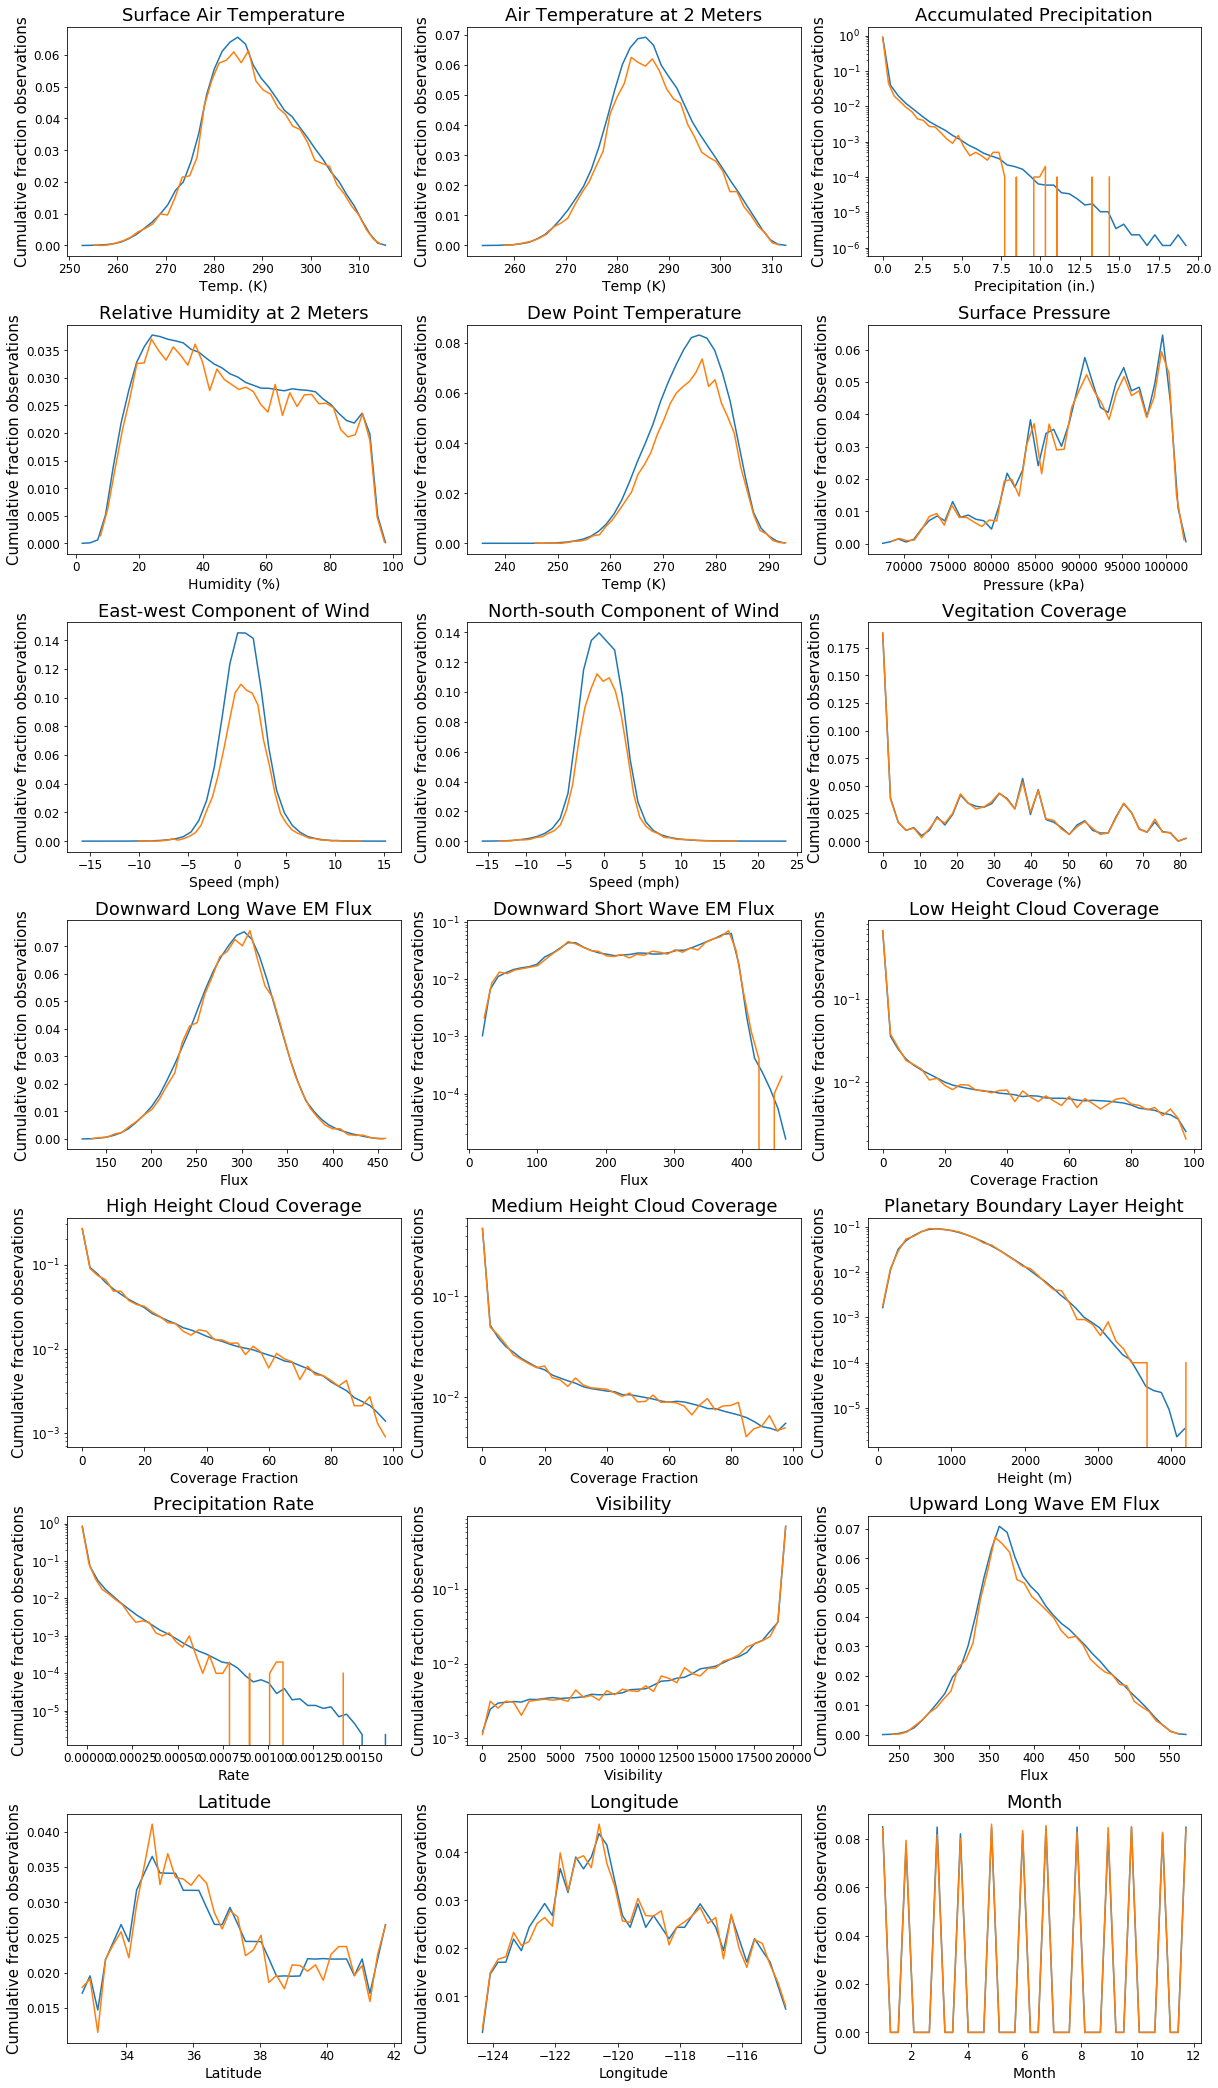

In [31]:
# Make density plots
xlabels = weather_variable_labels
ylabels = ['Cumulative fraction observations'] * len(xlabels)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = two_sample_density_plot(plot_locations[i], data, winning_sample, data_types[i], plot_titles[i], xlabels[i], ylabels[i], y_scales[i])
    
plt.show()

In [32]:
for variable in weather_variables:
    parent_data = np.array(data[variable])
    sample = np.array(winning_sample[variable])
    
    ks_result = ks_2samp(parent_data, sample)
    
    print("{} KS test p-value: {}".format(variable, np.round(ks_result[1],3)))

weather_bin_month KS test p-value: 0.998
weather_bin_year KS test p-value: 0.994
air.sfc KS test p-value: 0.994
air.2m KS test p-value: 0.999
apcp KS test p-value: 0.996
crain KS test p-value: 1.0
rhum.2m KS test p-value: 0.996
dpt.2m KS test p-value: 0.985
pres.sfc KS test p-value: 0.989
uwnd.10m KS test p-value: 0.999
vwnd.10m KS test p-value: 0.991
veg KS test p-value: 1.0
dlwrf KS test p-value: 0.989
dswrf KS test p-value: 0.995
lcdc KS test p-value: 0.967
hcdc KS test p-value: 0.989
mcdc KS test p-value: 0.993
hpbl KS test p-value: 0.992
prate KS test p-value: 0.991
vis KS test p-value: 1.0
ulwrf.sfc KS test p-value: 0.999
ignition KS test p-value: 1.0
